# Otimizador de Energia LoRa

Este script implementa um processo de otimização usando algoritmos evolutivos para minimizar a energia necessária para transmitir um pacote LoRa, dado um valor específico de RSSI. Ele explora combinações válidas de parâmetros de transmissão suportadas pelo módulo de rádio SX1276.

## Objetivo
Determinar a configuração ótima de:
- Potência de Transmissão (dBm)
- Fator de Espalhamento (SF)
- Largura de Banda (kHz)
- Taxa de Codificação (CR)

Que minimize a energia de transmissão garantindo que a margem do link (RSSI - Sensibilidade - SNR) permaneça acima de um limite definido.

## Principais Características
- Utiliza a biblioteca DEAP para otimização evolutiva
- Incorpora tabelas realistas de sensibilidade do SX1276 extraídas do datasheet
- Cálculo de energia baseado em interpolação do consumo de corrente e tempo de transmissão
- Execução paralela usando multiprocessing
- Geração de gráficos com energia, potência, SF e BW para todos os valores de RSSI

## Parâmetros Suportados pelo SX1276
A tabela abaixo mostra os valores discretos suportados para os principais parâmetros de transmissão do rádio SX1276:

| Fator de Espalhamento (SF) | Largura de Banda (kHz)                                 | Taxa de Codificação (CR) |
|----------------------------|---------------------------------------------------------|---------------------------|
| 6, 7, 8 ,9 10, 11, 12      | 7.8, 10.4, 15.6, 20.8, 31.25, 41.7, 62.5, 125, 250, 500 | 4/5, 4/6, 4/7, 4/8        |

Essas faixas definem os limites do processo de otimização e refletem as configurações práticas permitidas pelo SX1276 conforme especificado em seu datasheet.

## Equações Utilizadas
### Taxa de Símbolos
`Rs = BW / 2^SF`

### Tempo de Símbolo
`Ts = 1 / Rs`

### Símbolos do Payload
`npayload = 8 + max(ceil((8*PL - 4*SF + 28 + 16*CRC - 20*IH) / (4*(SF - 2*DE))) * (CR + 4), 0)`

### Tempo de Transmissão
`Tpacket = (npreamble + 4.25) * Tsym + npayload * Tsym`

### Energia
`E = I_mA * Vcc * Tpacket`

## Tabela de Sensibilidade
Interpolada a partir de valores do datasheet para combinações de SF e BW.

## SNR Mínimo por SF
| SF | SNR Mínimo (dB) |
|----|------------------|
| 6  | -5               |
| 7  | -7.5             |
| 8  | -10              |
| 9  | -12.5            |
| 10 | -15              |
| 11 | -17.5            |
| 12 | -20              |

## Consumo de Corrente
A corrente em mA é calculada com base em interpolação polinomial dos valores do datasheet.

## Preparo do ambiente
```bash
python3 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

## Limites de RSSI
O script processará valores de RSSI de -181 dBm a -100 dBm e exibirá gráficos com os parâmetros ótimos e o consumo de energia correspondente.

## Referências Bibliográficas

    Semtech SX1276 Datasheet. Disponível em: https://www.semtech.com/products/wireless-rf/lora-transceivers/sx1276

    DEAP: Distributed Evolutionary Algorithms in Python. https://github.com/DEAP/deap

    Goldberg, D.E. (1989). Genetic Algorithms in Search, Optimization and Machine Learning. Addison-Wesley.

    Haupt, R. L., & Haupt, S. E. (2004). Practical Genetic Algorithms. Wiley-Interscience.

    ÁVILA, SÉRGIO LUCIANO (2020). Otimização Paramétrica com Computação Evolutiva.

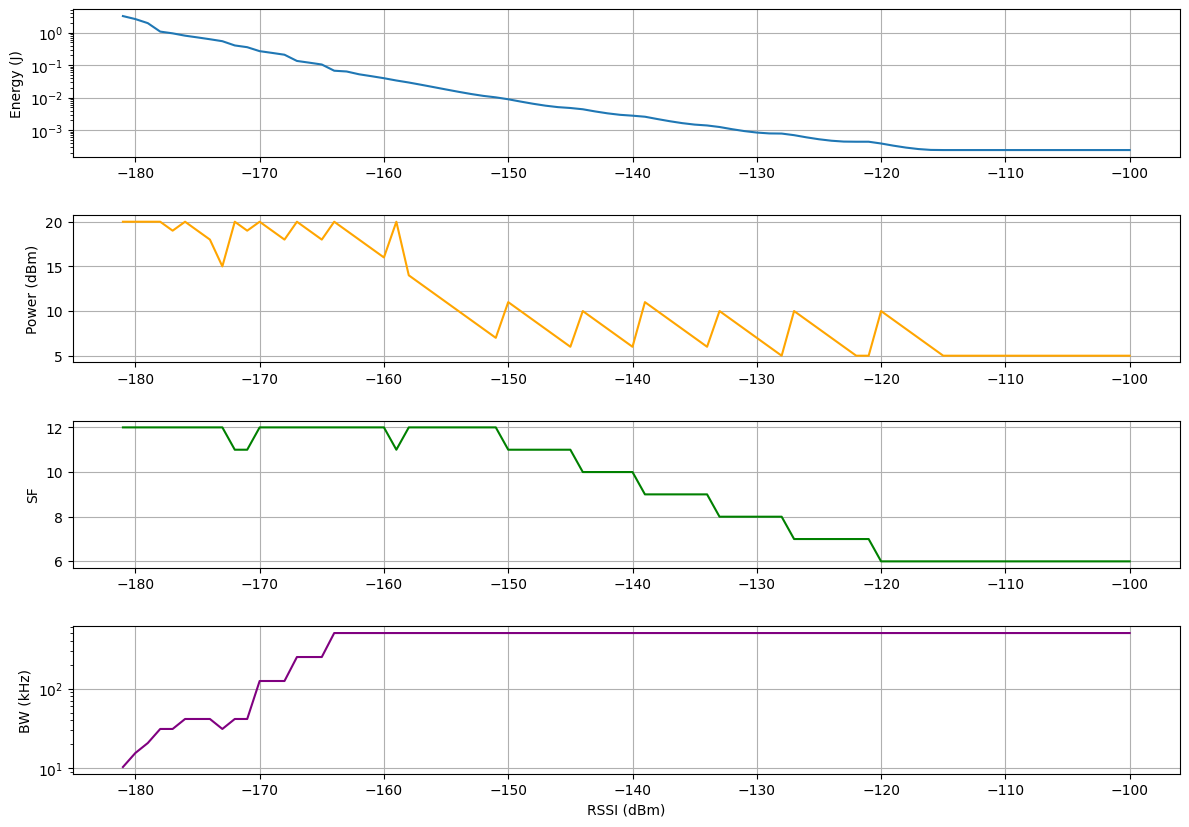

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import multiprocessing
import functools
from dataclasses import dataclass
import builtins

# === 1. CONFIGURAÇÕES ===
power_options = list(range(2, 21))  # Potência de transmissão em dBm
sf_options = list(range(6, 13))     # Spreading Factor de 6 a 12
bw_options = [7.8, 10.4, 15.6, 20.8, 31.25, 41.7, 62.5, 125.0, 250.0, 500.0]  # Larguras de banda em kHz
cr_options = [5, 6, 7, 8]  # Taxa de codificação representada como 4/CR

PAYLOAD_BYTES = 20  # Tamanho do payload em bytes
RSSI_MARGIN_MIN = 6  # Margem mínima de link em dB
POP_SIZE = 1000  # Tamanho da população para o algoritmo evolutivo
N_GEN = 100  # Número de gerações
PREAMBLE_SYMS = 8.0  # Número de símbolos do preâmbulo
IH = 0  # Header explícito
CRC = 1  # CRC habilitado
DE = 0  # Otimização da taxa de dados desabilitada

@dataclass
class LoRaParams:
    power: int
    sf: int
    bw: float
    cr: int

@dataclass
class LoRaResult:
    rssi: int
    params: LoRaParams
    energy: float
    rs: float
    ts: float

# === 2. MODELO DE SENSIBILIDADE ===
def calculate_sensitivity(sf, bw):
    # Tabela de sensibilidade extraída do datasheet
    sensitivity_table = {
        (6, 125.0): -118, (7, 125.0): -123, (8, 125.0): -126, (9, 125.0): -129, (10, 125.0): -132, (11, 125.0): -134, (12, 125.0): -136,
        (6, 250.0): -115, (7, 250.0): -120, (8, 250.0): -123, (9, 250.0): -125, (10, 250.0): -128, (11, 250.0): -130, (12, 250.0): -133,
        (6, 500.0): -111, (7, 500.0): -116, (8, 500.0): -119, (9, 500.0): -122, (10, 500.0): -125, (11, 500.0): -128, (12, 500.0): -130,
        (6, 62.5): -121, (7, 62.5): -126, (8, 62.5): -129, (9, 62.5): -132, (10, 62.5): -135, (11, 62.5): -137, (12, 62.5): -139,
        (6, 10.4): -131, (7, 10.4): -134, (8, 10.4): -138, (11, 10.4): -146,
        (11, 7.8): -145, (12, 7.8): -148
    }
    key = (sf, bw)
    if key in sensitivity_table:
        return sensitivity_table[key]

    # Interpolação linear se o valor não estiver na tabela
    known = [(k[1], v) for k, v in sensitivity_table.items() if k[0] == sf]
    if not known:
        raise ValueError(f"No sensitivity data for SF={sf}")
    known.sort()
    for i in range(len(known) - 1):
        bw0, s0 = known[i]
        bw1, s1 = known[i + 1]
        if bw0 <= bw <= bw1:
            return np.interp(bw, [bw0, bw1], [s0, s1])
    return known[-1][1] if bw > known[-1][0] else known[0][1]

# === 2B. TABELA POTÊNCIA x CORRENTE ===
def power_to_current(power):
    # Interpolação polinomial baseada em dados do datasheet
    coeffs = [10.768, -1.689, 0.153, 0.00076]
    return max(0, coeffs[0] + coeffs[1]*power + coeffs[2]*power**2 + coeffs[3]*power**3)

# === SNR por SF ===
snr_required = {6: -5, 7: -7.5, 8: -10, 9: -12.5, 10: -15, 11: -17.5, 12: -20}

# === 3. TEMPO DE TRANSMISSÃO ===
def symbol_rate(sf, bw):
    return (bw * 1000) / (2 ** sf)

def symbol_time(sf, bw):
    return 1 / symbol_rate(sf, bw)

def airtime(params: LoRaParams, payload_bytes):
    # Cálculo do tempo de transmissão baseado nas equações do LoRa
    tsym = symbol_time(params.sf, params.bw)
    t_preamble = (PREAMBLE_SYMS + 4.25) * tsym
    numerator = 8 * payload_bytes - 4 * params.sf + 28 + 16 * CRC - 20 * IH
    denominator = 4 * (params.sf - 2 * DE)
    n_payload = 8 + max(int(np.ceil(numerator / denominator)) * (params.cr + 4), 0)
    t_payload = n_payload * tsym
    return t_preamble + t_payload

# === 4. FUNÇÃO DE AVALIAÇÃO ===
def evaluate(ind, rssi_observed):
    # Avalia o indivíduo com base no consumo de energia
    params = LoRaParams(*ind)
    if params.sf not in sf_options or params.bw not in bw_options or params.cr not in cr_options or params.power not in power_options:
        return (1e9,)  # Penalização para parâmetros inválidos

    sensitivity = calculate_sensitivity(params.sf, params.bw)
    snr_min = snr_required.get(params.sf, -20)
    margin = params.power + rssi_observed - sensitivity - snr_min

    time_on_air = airtime(params, PAYLOAD_BYTES)
    current_ma = power_to_current(params.power)
    voltage = 3.3
    energy = (current_ma / 1000) * voltage * time_on_air

    if margin < RSSI_MARGIN_MIN:
        energy += 1e6  # Penaliza soluções com margem insuficiente

    return (energy,)

# === 5. CONFIGURAÇÃO DE DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def build_toolbox(rssi):
    # Cria toolbox de operadores para DEAP
    toolbox = base.Toolbox()
    toolbox.register("attr_power", lambda: random.choice(power_options))
    toolbox.register("attr_sf", lambda: random.choice(sf_options))
    toolbox.register("attr_bw", lambda: random.choice(bw_options))
    toolbox.register("attr_cr", lambda: random.choice(cr_options))
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_power, toolbox.attr_sf, toolbox.attr_bw, toolbox.attr_cr), 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", functools.partial(evaluate, rssi_observed=rssi))
    toolbox.register("map", builtins.map)
    return toolbox

# === 6. EXECUÇÃO PRINCIPAL ===
def run_optimization(rssi):
    # Executa otimização evolutiva para um valor de RSSI
    toolbox = build_toolbox(rssi)
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=N_GEN, halloffame=hof, verbose=False)
    best = hof[0]
    params = LoRaParams(*best)
    energy = evaluate(best, rssi)[0]
    rs = symbol_rate(params.sf, params.bw)
    ts = symbol_time(params.sf, params.bw)
    return LoRaResult(rssi, params, energy, rs, ts)

def plot_results(resultados):
    # Geração de gráficos para os resultados
    rssi_list = [r.rssi for r in resultados]
    energy_list = [r.energy for r in resultados]
    power_list = [r.params.power for r in resultados]
    sf_list = [r.params.sf for r in resultados]
    bw_list = [r.params.bw for r in resultados]

    plt.figure(figsize=(12, 10))

    plt.subplot(5, 1, 1)
    plt.plot(rssi_list, energy_list, label='Energy (J)')
    plt.ylabel('Energy (J)')
    plt.yscale('log')
    plt.grid(True)

    plt.subplot(5, 1, 2)
    plt.plot(rssi_list, power_list, label='Power (dBm)', color='orange')
    plt.ylabel('Power (dBm)')
    plt.grid(True)

    plt.subplot(5, 1, 3)
    plt.plot(rssi_list, sf_list, label='Spreading Factor', color='green')
    plt.ylabel('SF')
    plt.grid(True)

    plt.subplot(5, 1, 4)
    plt.plot(rssi_list, bw_list, label='Bandwidth (kHz)', color='purple')
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('BW (kHz)')
    plt.yscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Loop principal para otimizar diferentes valores de RSSI
    rssi_values = np.arange(-181, -99, 1)
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        resultados = pool.map(run_optimization, rssi_values)
    plot_results(resultados)

if __name__ == '__main__':
    main()
